In [3]:
import pandas as pd
from ast import literal_eval
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from statistics import mean, median
import scipy
from sklearn.decomposition import PCA
from sklearn import preprocessing
from gprofiler import GProfiler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
import operator
import qvalue as qv


#Reactome file containing information on pathways, the genes they contain and pathway name, also including the illumina identifier for the genes.

reactome = pd.read_csv('../data/reactome.csv', sep=',', index_col = 0)

def read_reactome(file_name, gene_name_start = "ENSG0"):
    df = pd.read_csv(file_name, sep='\t', header=None)
    
    if gene_name_start == None:
        sub_df = df
    else:
        subset_vec = df[0].str.startswith(gene_name_start)
        sub_df = df.loc[subset_vec]
    
    genes_df = sub_df.groupby(1)[0].apply(list)
    names_df = sub_df.groupby(1)[3].max()
    
    out_df = pd.concat([genes_df,names_df], axis=1)
    out_df.columns = ['genes', 'pathway_name']
    
    return out_df

low_level = read_reactome('../data/Ensembl2Reactome_All_Levels.txt.gz')

def my_pca(df, n_pc=1, normalize=True):
    df = df.dropna(axis = 0, how = 'all')#redundant, but keeping it just in case
    X = df.values.T
    if normalize:
        X2 = preprocessing.scale(X)
    else:
        X2 = X
    pca = PCA(n_components = n_pc)
    pca.fit(X2)
    my_pca.pca = pca  #needed for components
    Xnew = pca.fit_transform(X2)
    out_df = pd.DataFrame(Xnew.transpose(), index=list(range(1,n_pc+1)), columns=df.columns)
    out_df = out_df.transpose()
    
    return out_df, my_pca.pca.components_, my_pca.pca.explained_variance_ratio_

#Importing metabric dataset, dividing up what is clinical/expression data and changing the type of the expression columns to float
metabric_data = pd.read_csv('../data/metabric.csv.gz')
#clinical_data = metabric_data.iloc[:27, :]
expression_data = metabric_data.iloc[27:,:]

#print(expression_data.columns)
dtypedict = {}
for i in expression_data.columns[1:]:
    dtypedict[i] = 'float32'
expression_data = expression_data.astype(dtypedict)



new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)





genes = expression_data['Unnamed: 0'].values.tolist()

gp = GProfiler(return_dataframe = True)
gp = gp.convert(organism='hsapiens',
          query=genes)

gp = gp.loc[gp['n_converted'] == 1]
gp = gp.loc[gp['name'] != 'None']
gp = gp.set_index('incoming')
gprofiler_names = gp
gprofiler_names

dataset = expression_data.set_index('Unnamed: 0') #gene_patient
pca_per_pathway = pd.DataFrame(index=expression_data.columns)

real_gene_names = pd.read_csv('../data/illumina2symbol.txt', sep="\t", index_col = 0)



genes_components_per_pathway = {} #nested dictionary where the 'outer dictionary' is the pathway names as keys and values are 
                                  #another dictionary with genes as keys and components as values

for pathway in reactome.index:
    genes = reactome.loc[pathway, "illumina"]
    genes = literal_eval(genes)
    genes = list(filter(lambda a: a != 'NaN', genes))
    pathwaydata = dataset.loc[genes]
    if pathwaydata.index.empty == True:
        pass
    else:
        pathwaydata = pathwaydata.dropna(axis = 0, how = 'any') #has to be done so the lists match, this makes the dropna in my_pca function obsolete
        presentgenes = pathwaydata.index.values.tolist()
        if len(presentgenes) <= 1:
            pass
        else:
            res, components, explained_variance = my_pca(pathwaydata)
            pathwayname = reactome.loc[pathway, 'pathway_name']
            pca_per_pathway[pathwayname] = res

            components = components.tolist()[0]
            innerdict = {}
            for i in range(0, len(presentgenes)):
                component = components[i]
                gene = genes[i]
                if gene in real_gene_names.index:
                    real_name = real_gene_names.loc[gene, "symbol"]
                    innerdict[real_name] = component
                elif gene in gprofiler_names.index:
                    real_name = gprofiler_names.loc[gene, 'name']
                    innerdict[real_name] = component
                else:
                    innerdict[gene] = component
            sorted_innerdict = sorted(innerdict.items(), key = operator.itemgetter(1), reverse = True)
            genes_components_per_pathway[pathwayname] = [sorted_innerdict, explained_variance.flat[0]]

pca_per_pathway = pca_per_pathway.iloc[1:]

In [4]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)


In [5]:
size = full_df['Tumor Size'].astype(float)
size[size >= 100]

MB-0112    150.0
MB-0406    180.0
MB-0453    100.0
MB-0656    100.0
MB-0657    100.0
MB-0660    160.0
MB-3436    130.0
MB-6063    120.0
MB-7148    130.0
MB-7165    182.0
Name: Tumor Size, dtype: float64

In [6]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv


grouped_ttest = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df = group[1].iloc[:,:-33]
    groupname = group[0]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2)
        pvaluelist.append(test[1])
        
    empty_df = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    
    empty_df[f'Cluster {groupname} p-values'] = pvaluelist
    print(empty_df)
    qv.qvalues(empty_df, f'Cluster {groupname} p-values', f'Cluster {groupname} q-values')
    empty_df[f'Cluster {groupname} p-values'] = -np.log10(empty_df[f'Cluster {groupname} p-values'])
    empty_df[f'Cluster {groupname} q-values'] = -np.log10(empty_df[f'Cluster {groupname} q-values'])
    print(empty_df)
    grouped_ttest = pd.concat([grouped_ttest, empty_df], axis = 1)    
        
grouped_ttest

                                                    Cluster 1 p-values
Interleukin-6 signaling                                       0.000519
Apoptosis                                                     0.000032
Hemostasis                                                    0.001655
Intrinsic Pathway for Apoptosis                               0.097446
PKB-mediated events                                           0.002635
...                                                                ...
Antigen activates B Cell Receptor (BCR) leading...            0.274777
Signaling by the B Cell Receptor (BCR)                        0.060090
Ion channel transport                                         0.001950
Activation of GABAB receptors                                 0.000487
Inhibition  of voltage gated Ca2+ channels via ...            0.002477

[2074 rows x 1 columns]
                                                    Cluster 1 p-values  \
Chromosome Maintenance                           

                                                    Cluster 3 p-values  \
KSRP (KHSRP) binds and destabilizes mRNA                     51.833277   
Factors involved in megakaryocyte development a...           50.970782   
Cyclin A/B1/B2 associated events during G2/M tr...           50.553874   
Mitotic Telophase/Cytokinesis                                49.688706   
COPI-dependent Golgi-to-ER retrograde traffic                47.921327   
...                                                                ...   
Vasopressin-like receptors                                    0.306402   
Cellular responses to stress                                  0.306015   
FasL/ CD95L signaling                                         0.305937   
STING mediated induction of host immune responses             0.305376   
Signaling by Insulin receptor                                 0.301930   

                                                    Cluster 3 q-values  
KSRP (KHSRP) binds and destabilizes mR

                                                    Cluster 5 p-values  \
Metabolism of amine-derived hormones                         61.053896   
Catecholamine biosynthesis                                   52.603890   
GRB7 events in ERBB2 signaling                               45.011925   
Tryptophan catabolism                                        40.794582   
Fertilization                                                40.407741   
...                                                                ...   
Digestion and absorption                                      0.303727   
Synthesis And Processing Of GAG, GAGPOL Polypro...            0.303495   
Membrane binding and targetting of GAG proteins               0.303403   
Hypusine synthesis from eIF5A-lysine                          0.302019   
Cytosolic sensors of pathogen-associated DNA                  0.301559   

                                                    Cluster 5 q-values  
Metabolism of amine-derived hormones  

                                                    Cluster 9 p-values
Interleukin-6 signaling                                       0.000019
Apoptosis                                                     0.324966
Hemostasis                                                    0.000409
Intrinsic Pathway for Apoptosis                               0.413832
PKB-mediated events                                           0.061776
...                                                                ...
Antigen activates B Cell Receptor (BCR) leading...            0.434673
Signaling by the B Cell Receptor (BCR)                        0.357584
Ion channel transport                                         0.000012
Activation of GABAB receptors                                 0.175437
Inhibition  of voltage gated Ca2+ channels via ...            0.300155

[2074 rows x 1 columns]
                                                    Cluster 9 p-values  \
Vitamin B2 (riboflavin) metabolism               

,Cluster 1 p-values,Cluster 1 q-values,Cluster 10 p-values,Cluster 10 q-values,Cluster 2 p-values,Cluster 2 q-values,Cluster 3 p-values,Cluster 3 q-values,Cluster 4ER+ p-values,Cluster 4ER+ q-values,...,Cluster 5 p-values,Cluster 5 q-values,Cluster 6 p-values,Cluster 6 q-values,Cluster 7 p-values,Cluster 7 q-values,Cluster 8 p-values,Cluster 8 q-values,Cluster 9 p-values,Cluster 9 q-values
Interleukin-6 signaling,3.285109,2.896183,7.090792,6.909434,1.685785,1.207825,4.171840,3.813117,10.622985,10.125721,...,2.845952,2.505034,2.971081,2.320790,1.132267,1.027113,7.408501,7.088204,4.720522,4.144865
Apoptosis,4.498541,4.022465,59.011315,58.237332,0.370636,0.336449,6.374748,5.880107,0.551906,0.522675,...,3.845343,3.417836,0.386531,0.353928,11.961576,11.101133,24.478288,23.662539,0.488162,0.433804
Hemostasis,2.781245,2.425857,30.312820,29.862299,2.357832,1.626484,0.836917,0.759157,21.128807,20.215119,...,4.696436,4.205053,5.017376,3.910083,12.755542,11.815310,46.742077,45.106510,3.388050,2.943398
Intrinsic Pathway for Apoptosis,1.011234,0.859075,88.170630,86.999949,0.910047,0.676740,5.347793,4.906045,6.451754,6.112669,...,6.941377,6.293885,0.392107,0.356786,20.312605,18.751671,9.487835,9.116495,0.383176,0.356847
PKB-mediated events,2.579178,2.250036,4.394060,4.258809,0.479164,0.401905,1.335432,1.199609,8.372921,7.969927,...,1.591553,1.381615,1.307871,1.048555,5.709229,5.306763,9.151857,8.788808,1.209177,1.026546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Antigen activates B Cell Receptor (BCR) leading to generation of second messengers,0.561020,0.487497,20.637182,20.292576,1.742695,1.241464,0.341322,0.333078,11.406933,10.868276,...,6.476075,5.854748,3.894631,3.030814,8.140994,7.563757,46.515136,44.888523,0.361837,0.342570
Signaling by the B Cell Receptor (BCR),1.221199,1.039204,40.008994,39.432548,1.275575,0.926315,1.950339,1.756275,5.222868,4.935443,...,5.423113,4.887341,2.750312,2.171491,9.786682,9.095186,45.043304,43.559004,0.446621,0.403046
Ion channel transport,2.710035,2.363573,99.770882,98.280148,7.791947,5.589081,0.796511,0.722492,3.940780,3.707115,...,13.601545,12.597721,5.958872,4.610546,35.601750,32.585971,32.027620,31.028875,4.911030,4.315207
Activation of GABAB receptors,3.312476,2.922010,17.601944,17.288596,0.691484,0.535144,4.919382,4.511594,1.241040,1.148505,...,2.260713,1.978533,0.678105,0.554421,4.610404,4.272232,14.220288,13.729554,0.755880,0.644275


In [7]:
grouped_ttest.loc['Cell Cycle']

Cluster 1 p-values        17.792930
Cluster 1 q-values        16.449249
Cluster 10 p-values      105.193740
Cluster 10 q-values      103.132204
Cluster 2 p-values         1.675756
Cluster 2 q-values         1.201556
Cluster 3 p-values        45.929201
Cluster 3 q-values        43.691573
Cluster 4ER+ p-values     44.653553
Cluster 4ER+ q-values     42.783902
Cluster 4ER- p-values      1.033751
Cluster 4ER- q-values      0.918066
Cluster 5 p-values        19.062704
Cluster 5 q-values        17.741685
Cluster 6 p-values         3.170968
Cluster 6 q-values         2.472260
Cluster 7 p-values         8.998319
Cluster 7 q-values         8.356371
Cluster 8 p-values        15.567307
Cluster 8 q-values        15.037958
Cluster 9 p-values        13.357865
Cluster 9 q-values        11.853969
Name: Cell Cycle, dtype: float64

In [14]:
for i in clusterframes:
    print(clusterframes[i].loc['Cell Cycle'].iloc[4:])

cluster 1 qvalues    16.449249
Name: Cell Cycle, dtype: float64
cluster 10 qvalues    103.132204
Name: Cell Cycle, dtype: float64
cluster 2 qvalues    1.201556
Name: Cell Cycle, dtype: float64
cluster 3 qvalues    43.691573
Name: Cell Cycle, dtype: float64
cluster 4ER+ qvalues    42.783902
Name: Cell Cycle, dtype: float64
cluster 4ER- qvalues    0.918066
Name: Cell Cycle, dtype: float64
cluster 5 qvalues    17.741685
Name: Cell Cycle, dtype: float64
cluster 6 qvalues    2.47226
Name: Cell Cycle, dtype: float64
cluster 7 qvalues    8.356371
Name: Cell Cycle, dtype: float64
cluster 8 qvalues    15.037958
Name: Cell Cycle, dtype: float64
cluster 9 qvalues    11.853969
Name: Cell Cycle, dtype: float64


In [9]:
grouped_ttest.to_csv('../exp/pathway_qvalues.csv')

In [10]:
grouped_ttest.sort_values(by='Cluster 7 q-values', ascending=False).iloc[:30,:]

,Cluster 1 p-values,Cluster 1 q-values,Cluster 10 p-values,Cluster 10 q-values,Cluster 2 p-values,Cluster 2 q-values,Cluster 3 p-values,Cluster 3 q-values,Cluster 4ER+ p-values,Cluster 4ER+ q-values,...,Cluster 5 p-values,Cluster 5 q-values,Cluster 6 p-values,Cluster 6 q-values,Cluster 7 p-values,Cluster 7 q-values,Cluster 8 p-values,Cluster 8 q-values,Cluster 9 p-values,Cluster 9 q-values
Cytosolic iron-sulfur cluster assembly,1.703884,1.456003,24.094279,23.718982,0.764237,0.579368,0.697590,0.636295,25.623755,24.564625,...,5.553411,5.008190,1.319507,1.057311,37.119923,33.803114,43.559845,42.162114,5.406255,4.772493
Ion channel transport,2.710035,2.363573,99.770882,98.280148,7.791947,5.589081,0.796511,0.722492,3.940780,3.707115,...,13.601545,12.597721,5.958872,4.610546,35.601750,32.585971,32.027620,31.028875,4.911030,4.315207
Ubiquinol biosynthesis,4.079269,3.629338,105.309280,103.214748,0.752076,0.571538,14.175160,13.414654,1.326406,1.227870,...,25.056345,23.330601,0.784752,0.637030,32.449809,29.610121,51.067608,49.182163,1.565955,1.334814
CaM pathway,2.722923,2.375107,93.526336,92.260407,3.464208,2.358597,2.525075,2.280884,8.540082,8.130147,...,8.177666,7.451922,2.578089,2.037255,30.709111,28.169780,43.995364,42.565046,3.163195,2.734566
Calmodulin induced events,2.722500,2.375107,93.524138,92.260407,3.463215,2.358597,2.525368,2.280884,8.538278,8.128881,...,8.180024,7.453165,2.578089,2.037255,30.709111,28.169780,44.000023,42.565046,3.162294,2.734226
RUNX1 regulates estrogen receptor mediated transcription,2.793252,2.437389,98.185827,96.772108,4.983323,3.398908,6.537761,6.039179,2.824077,2.640488,...,26.058963,24.247304,5.630535,4.374424,30.708438,28.169780,36.422982,35.267541,3.155543,2.728035
Ca-dependent events,2.491452,2.171593,95.210570,93.893761,3.431523,2.342601,2.726962,2.464231,8.073920,7.681390,...,8.224898,7.493550,2.365233,1.883481,30.563871,28.092160,45.365887,43.855259,2.816312,2.418582
DAG and IP3 signaling,0.615195,0.530874,105.951164,103.713537,3.756526,2.533138,12.027912,11.338469,0.317666,0.316198,...,21.702121,20.141187,0.951195,0.766326,30.480652,28.066933,43.352823,41.965433,0.473219,0.422995
Amino acids regulate mTORC1,2.710668,2.363741,72.560216,71.637859,10.058843,7.520185,0.986195,0.885288,0.875335,0.812509,...,13.384960,12.396531,1.948104,1.547003,30.227688,27.865122,13.612229,13.129841,2.521020,2.152624
RUNX1 regulates transcription of genes involved in WNT signaling,2.126980,1.842790,39.889120,39.315036,2.657070,1.842689,0.315284,0.312343,19.978043,19.114553,...,15.260979,14.164278,2.296705,1.826852,30.017712,27.700903,54.227634,52.166098,4.890615,4.296440


In [11]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2)
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        
#clusterframes

1
10
2
3
4ER+
4ER-
5
6
7
8
9


In [12]:
clusterframes['5'][clusterframes['5']['cluster 5 qvalues'] > 3].shape

(839, 5)

In [13]:
for i in new_clinical.columns:
    print(i)

Lymph nodes examined positive
Nottingham prognostic index
Cellularity
Chemotherapy
Cohort
ER status measured by IHC
HER2 status measured by SNP6
Hormone Therapy
Inferred Menopausal State
Integrative Cluster
Age at Diagnosis
Overall Survival (Months)
Overall Survival Status
Pam50 + Claudin-low subtype
3-Gene classifier subtype
Patient's Vital Status
Primary Tumor Laterality
Radio Therapy
Tumor Other Histologic Subtype
Type of Breast Surgery
Sample Identifier
Cancer Type
Cancer Type Detailed
ER Status
HER2 Status
Neoplasm Histologic Grade
Oncotree Code
PR Status
Sample Type
Tumor Size
Tumor Stage
Triple Neg
ER-/PR-/HER2+


In [15]:
clinical_cat = 'ER-/PR-/HER2+'
def cluster_clin(clinical_cat, clustergroups):
    ER_pos_neg = full_df.groupby(clustergroups)
    print('total')
    full_grp = full_df[clinical_cat].value_counts()
    full_series_len = full_df[clinical_cat].count()
    full_grp_df = pd.DataFrame()
    full_grp_df['counts'] = full_grp
    full_grp_df['%'] = round(100*(full_grp/full_series_len),2)
    print(full_grp_df)
    print('\n\n\n')
    for group in ER_pos_neg:
        grp = group[1]
        grp2 = grp[clinical_cat].value_counts()
        series_len = grp[clinical_cat].count()
        df = pd.DataFrame()
        df['counts'] = grp2
        df['%'] = round(100*(grp2/series_len),2)
        print(f'cluster {group[0]}')
        print(df)
        print()
cluster_clin('Pam50 + Claudin-low subtype', 'Integrative Cluster')

total
             counts      %
LumA            700  35.35
LumB            475  23.99
Her2            224  11.31
claudin-low     218  11.01
Basal           209  10.56
Normal          148   7.47
NC                6   0.30




cluster 1
             counts      %
LumB             89  64.03
Her2             19  13.67
LumA             11   7.91
Basal             8   5.76
Normal            8   5.76
claudin-low       4   2.88

cluster 10
             counts      %
Basal           143  63.27
claudin-low      60  26.55
LumB             14   6.19
Her2              7   3.10
Normal            1   0.44
LumA              1   0.44

cluster 2
             counts      %
LumB             35  48.61
LumA             25  34.72
Her2              5   6.94
claudin-low       3   4.17
Normal            3   4.17
Basal             1   1.39

cluster 3
             counts      %
LumA            192  66.21
LumB             38  13.10
Normal           34  11.72
claudin-low      13   4.48
Her2              8   2.76
N

In [16]:
cluster_clin("ER Status", 'Integrative Cluster')

total
          counts      %
Positive    1511  76.12
Negative     474  23.88




cluster 1
          counts      %
Positive     123  88.49
Negative      16  11.51

cluster 10
          counts      %
Negative     201  88.94
Positive      25  11.06

cluster 2
          counts      %
Positive      69  95.83
Negative       3   4.17

cluster 3
          counts      %
Positive     278  95.86
Negative      12   4.14

cluster 4ER+
          counts      %
Positive     230  88.46
Negative      30  11.54

cluster 4ER-
          counts      %
Negative      75  90.36
Positive       8   9.64

cluster 5
          counts      %
Negative     111  58.42
Positive      79  41.58

cluster 6
          counts      %
Positive      85  100.0

cluster 7
          counts      %
Positive     187  98.42
Negative       3   1.58

cluster 8
          counts      %
Positive     297  99.33
Negative       2   0.67

cluster 9
          counts      %
Positive     125  85.62
Negative      21  14.38



In [17]:
clus5 = new_clinical[new_clinical['Integrative Cluster'] == '']
clus5['Age at Diagnosis'].astype(float).median()

nan

In [18]:
clusterframes['6'].iloc[:45,:]

,Cluster 6,Other clusters,Fold Change,p-values,cluster 6 qvalues
Signaling by plasma membrane FGFR1 fusions,4.063803,-0.181134,4.487698,51.157171,47.840363
FGFR1 mutant receptor activation,2.576108,-0.114824,4.487698,26.410289,23.394510
TRAIL signaling,-1.258103,0.056077,4.487698,18.662574,15.822886
Repression of WNT target genes,-1.173984,0.052328,4.487698,15.769200,13.054451
FGFR1b ligand binding and activation,1.105800,-0.049288,4.487698,15.648199,13.030361
FGFR1c and Klotho ligand binding and activation,0.995793,-0.044385,4.487699,14.267684,11.729027
RUNX3 regulates WNT signaling,-1.081897,0.048223,4.487698,13.642549,11.170838
Protein repair,-1.191579,0.053112,4.487698,13.098648,10.684929
RUNX3 regulates CDKN1A transcription,-0.868610,0.038716,4.487698,11.722635,9.360069
Activated NTRK2 signals through CDK5,0.782766,-0.034890,4.487698,11.480291,9.163482


In [19]:
full_clusterframe = pd.DataFrame(index=clusterframes['1'].index)
for i in clusterframes:
    series = clusterframes[i][f'cluster {i} qvalues']
    full_clusterframe = pd.concat([full_clusterframe, series.reindex(full_clusterframe.index)], axis=1)


In [20]:
full_clusterframe.to_csv("../data/pathway_qvalues.csv")

In [21]:
full_clusterframe.sort_values(by='cluster 6 qvalues', ascending = False)

,cluster 1 qvalues,cluster 10 qvalues,cluster 2 qvalues,cluster 3 qvalues,cluster 4ER+ qvalues,cluster 4ER- qvalues,cluster 5 qvalues,cluster 6 qvalues,cluster 7 qvalues,cluster 8 qvalues,cluster 9 qvalues
Signaling by plasma membrane FGFR1 fusions,1.056540,5.657753,0.858001,1.135897,4.989607,1.124523,12.315146,47.840363,0.407385,0.419033,0.363758
FGFR1 mutant receptor activation,7.605941,1.704010,2.932583,7.708994,3.516649,7.066560,2.154114,23.394510,0.852150,0.543041,0.539604
TRAIL signaling,6.051372,1.664447,6.324815,2.689737,4.485632,12.251420,2.200168,15.822886,0.974160,0.665045,4.978419
Repression of WNT target genes,7.830698,87.904247,6.316455,0.346886,6.073662,10.099087,4.999093,13.054451,15.757829,20.375811,1.709645
FGFR1b ligand binding and activation,5.573487,2.207001,0.518688,1.023700,10.639769,0.311369,7.975760,13.030361,0.593345,1.645243,4.655440
...,...,...,...,...,...,...,...,...,...,...,...
NR1H2 & NR1H3 regulate gene expression linked to gluconeogenesis,0.965697,4.545663,0.694227,1.181383,0.778764,0.347487,1.900253,0.301864,0.393573,0.440116,1.615378
Host Interactions of HIV factors,5.257473,50.879216,0.327793,5.654838,0.634917,1.421628,2.743062,0.301605,8.293289,25.502153,0.414512
Amine Oxidase reactions,0.669262,52.359019,4.192886,12.531851,8.282304,12.223373,17.194250,0.301288,10.939366,9.749934,1.627398
"Defective CHST14 causes EDS, musculocontractural type",4.994936,27.927367,1.301636,19.474214,10.796627,3.016192,0.644486,0.301288,0.311294,0.585299,4.817250


In [22]:
clus9 = clusterframes['5']
clus9[clus9['cluster 5 qvalues'] > 2]

,Cluster 5,Other clusters,Fold Change,p-values,cluster 5 qvalues
Metabolism of amine-derived hormones,1.606009,-0.169335,3.245528,61.053896,57.737087
Catecholamine biosynthesis,1.450386,-0.152926,3.245528,52.603890,49.588111
GRB7 events in ERBB2 signaling,-1.268629,0.133762,3.245528,45.011925,42.172238
Tryptophan catabolism,1.772766,-0.186918,3.245528,40.794582,38.079833
Fertilization,1.847048,-0.194750,3.245527,40.407741,37.789902
...,...,...,...,...,...
VEGFR2 mediated vascular permeability,0.327580,-0.034539,3.245531,2.302145,2.014720
Other semaphorin interactions,0.234653,-0.024741,3.245526,2.300813,2.013793
Synthesis of active ubiquitin: roles of E1 and E2 enzymes,-0.333415,0.035155,3.245527,2.294655,2.008041
RUNX3 regulates RUNX1-mediated transcription,0.152915,-0.016123,3.245531,2.290500,2.004291


In [23]:
genes_components_per_pathway['Cell-Cell communication'][0]


[('SIRPA', 0.20933493971824646),
 ('LIMS2', 0.20184558629989624),
 ('ACTN1', 0.19790655374526978),
 ('NECTIN3', 0.19344712793827057),
 ('KRT5', 0.18999922275543213),
 ('CDH3', 0.18161934614181519),
 ('FERMT2', 0.1795758754014969),
 ('FLNC', 0.1743280291557312),
 ('KRT14', 0.16744810342788696),
 ('LAMB3', 0.15524908900260925),
 ('COL17A1', 0.1528327912092209),
 ('CLDN5', 0.14909696578979492),
 ('KIRREL1', 0.14352978765964508),
 ('CDH5', 0.1395282745361328),
 ('CLDN11', 0.13898733258247375),
 ('ITGB1', 0.13500061631202698),
 ('ACTN4', 0.13409370183944702),
 ('CADM3', 0.12490791082382202),
 ('ACTB', 0.12114709615707397),
 ('CD47', 0.1202237457036972),
 ('DST', 0.10406628996133804),
 ('SIRPG', 0.10371331125497818),
 ('CLDN23', 0.1036016047000885),
 ('ITGB4', 0.10045647621154785),
 ('FYB1', 0.09968709945678711),
 ('FLNA', 0.09956575930118561),
 ('FBLIM1', 0.09528274834156036),
 ('RSU1', 0.09308785945177078),
 ('CDH11', 0.09262821078300476),
 ('FYN', 0.09123032540082932),
 ('LAMC2', 0.089208

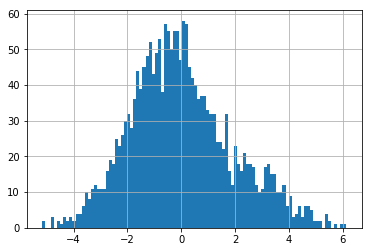

In [24]:
pca_per_pathway['Calmodulin induced events'].hist(bins=100)

In [27]:
from statsmodels.formula.api import ols
results = ols("Q('M Phase') ~C(Q('Integrative Cluster'))", data=full_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Q('M Phase')   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     246.8
Date:                Tue, 24 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:21:56   Log-Likelihood:                -5995.0
No. Observations:                1980   AIC:                         1.201e+04
Df Residuals:                    1969   BIC:                         1.207e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               4.9120      0.425     11.557      0.000       4.078       5.746
C(Q('Integrative Cluster'))[T.10]       6.9656      0.540     12.896      0.000       5.906       8.025
C(Q('Integrative Cluster'))[T.2]       -4.1970      0.728     -5.768      0.000      -5.624      -2.770
C(Q('Integrative Cluster'))[T.3]      -10.0374      0.517    -19.417      0.000     -11.051      -9.024
C(Q('Integrative Cluster'))[T.4ER+]   -10.3933      0.527    -19.740      0.000     -11.426      -9.361
C(Q('Integrative Cluster'))[T.4ER-]    -6.2301      0.695     -8.963      0.000      -7.593      -4.867
C(Q('Integrative Cluster'))[T.5]       -1.1106      0.559     -1.986      0.047      -2.207      -0.014
C(Q('Integrative Cluster'))[T.6]       -3.3190      0.690     -4.810      0.000      -4.672      -1.966
C(Q('Integrative Cluster'))[T.7]       -8.5458      0.559    -15.280      0.000      -9.643      -7.449
C(Q('Integrative Cluster'))[T.8]       -8.4974      0.514    -16.518      0.000      -9.506      -7.488
C(Q('Integrative Cluster'))[T.9]       -1.3844      0.594     -2.331      0.020      -2.549      -0.220
==============================================================================
Omnibus:                       20.848   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.233
Skew:                           0.251   Prob(JB):                     2.45e-05
Kurtosis:                       3.067   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

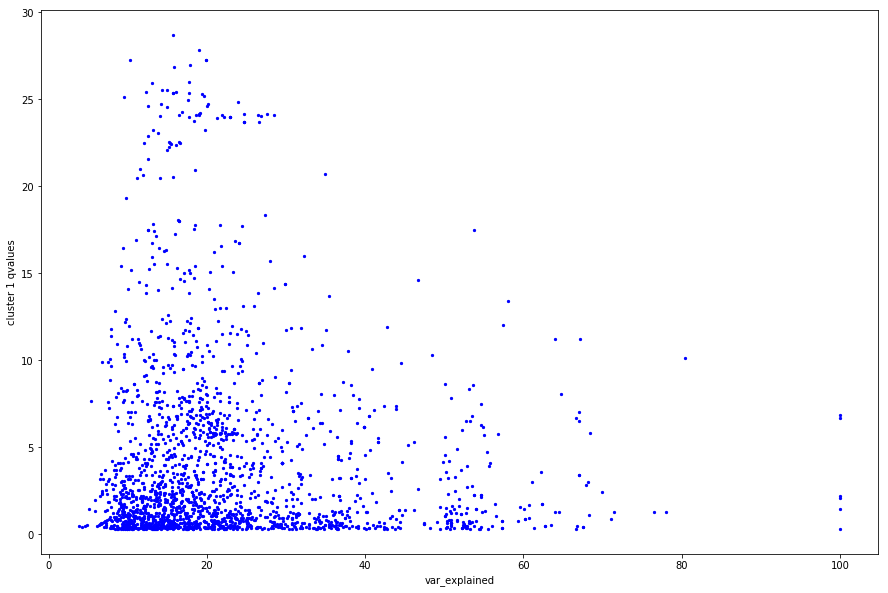

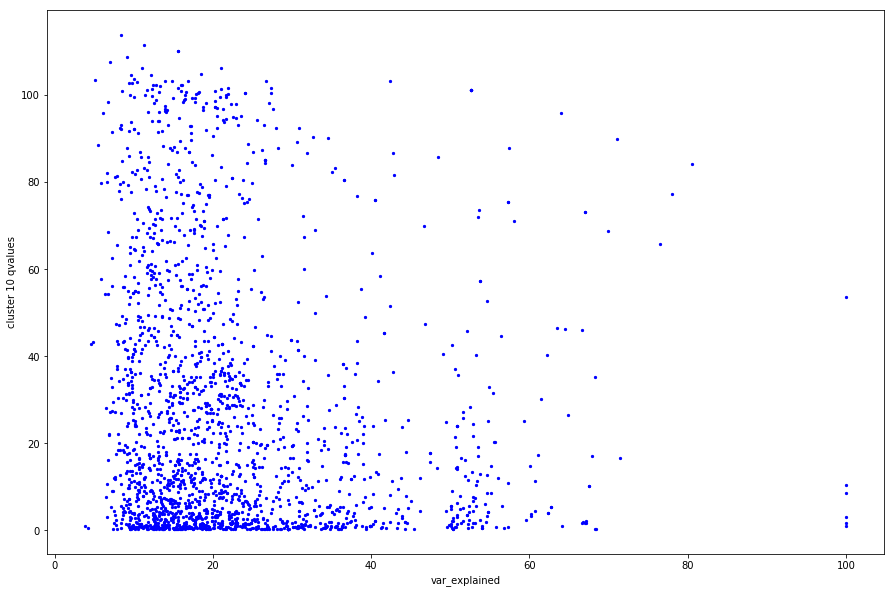

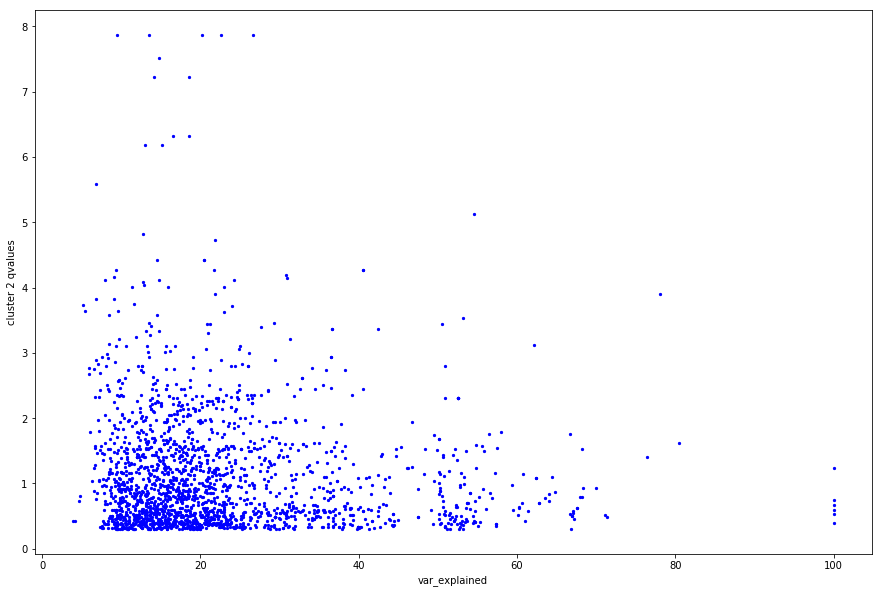

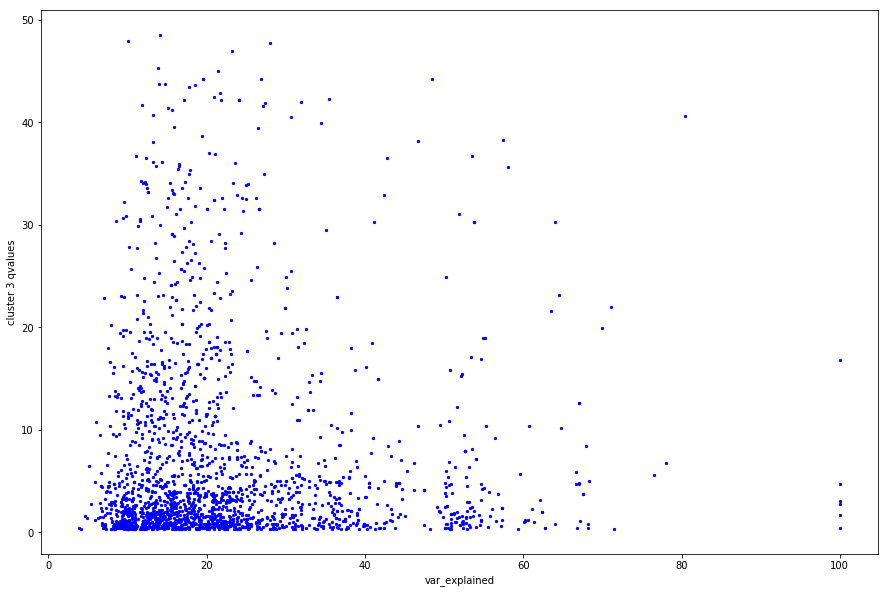

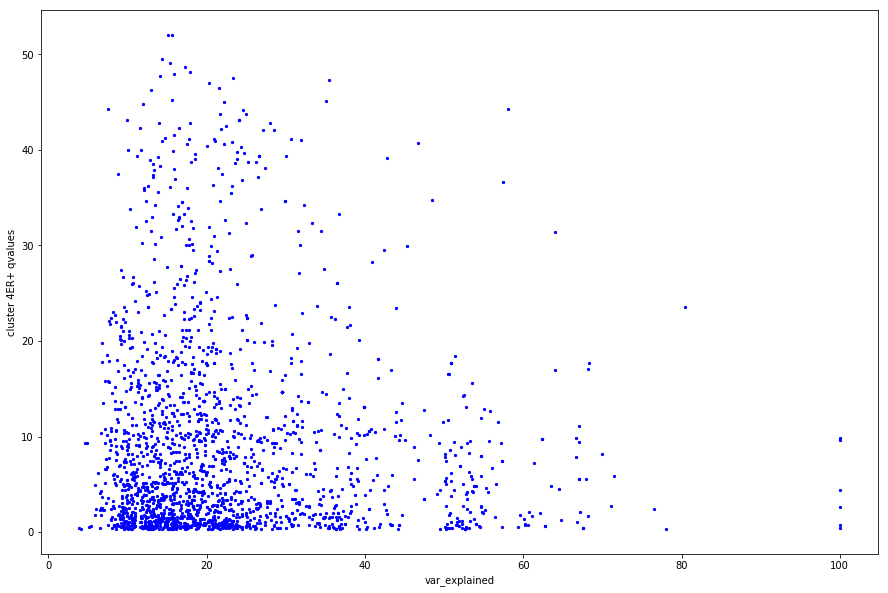

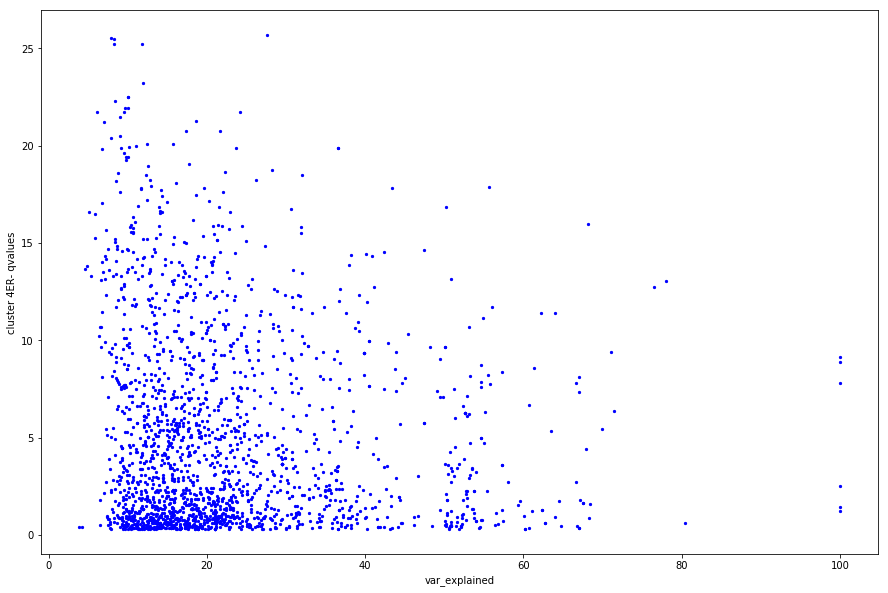

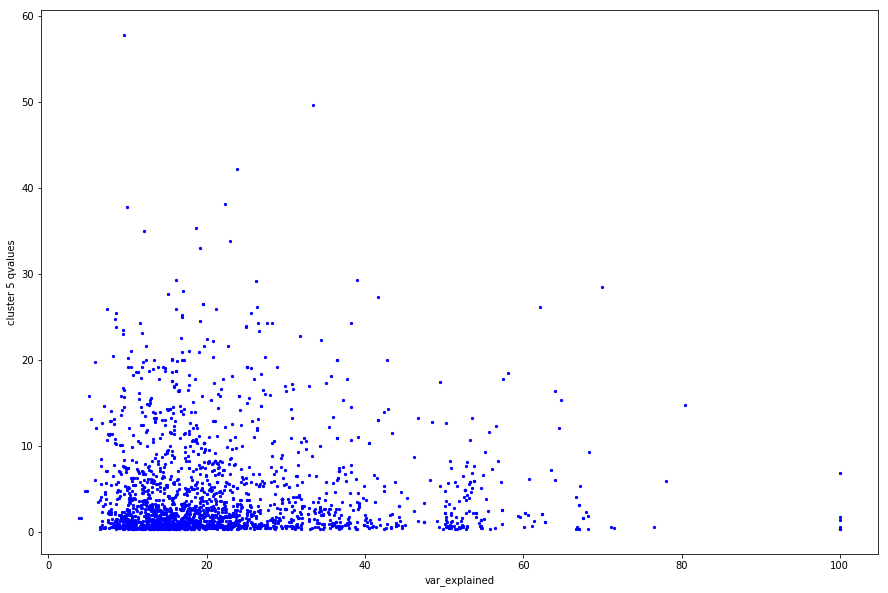

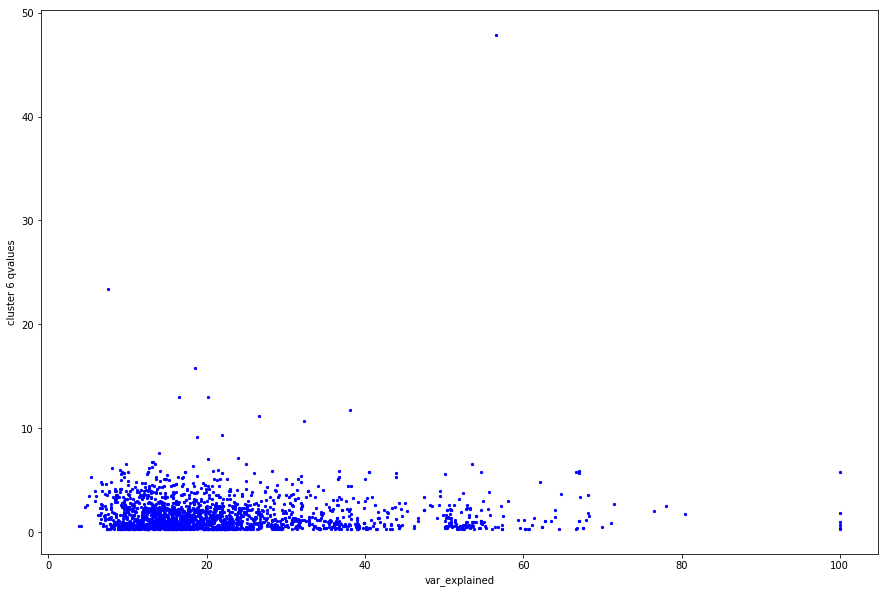

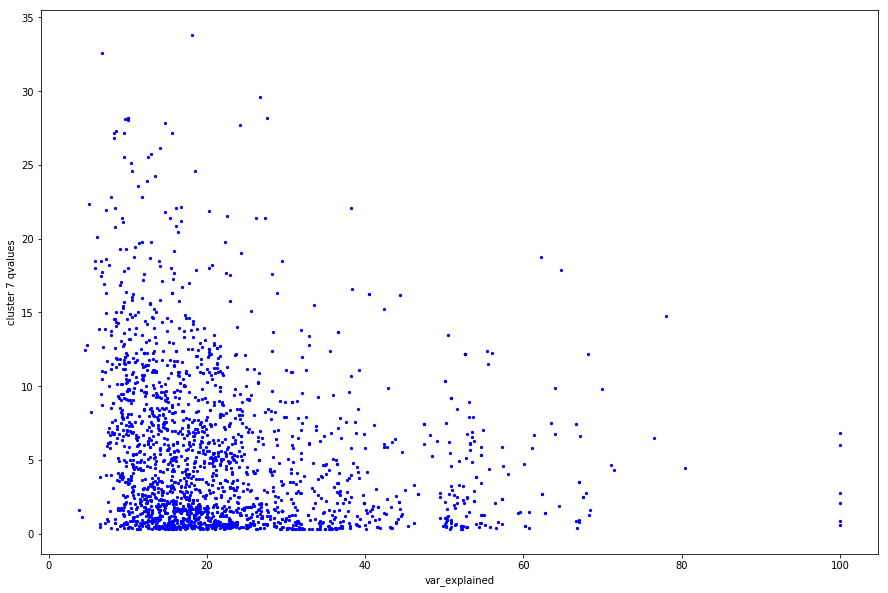

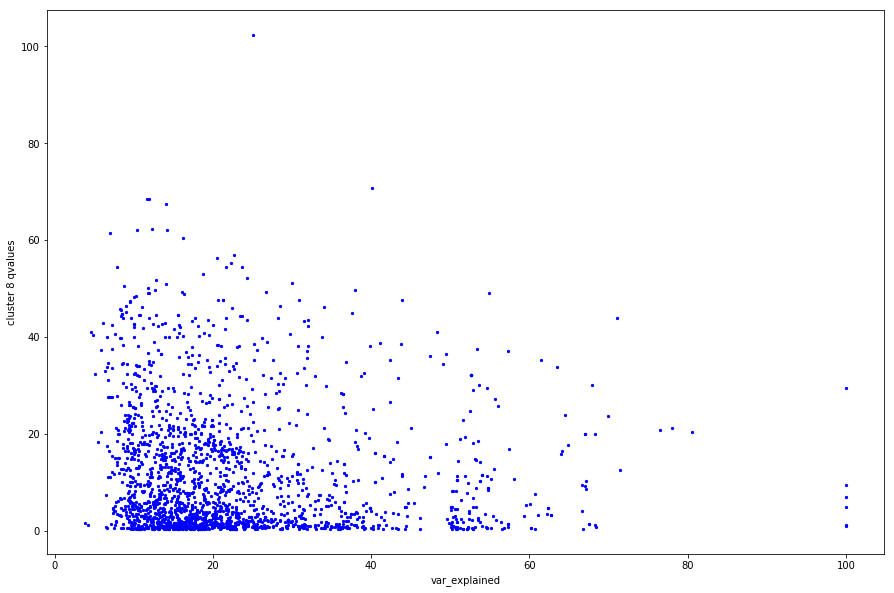

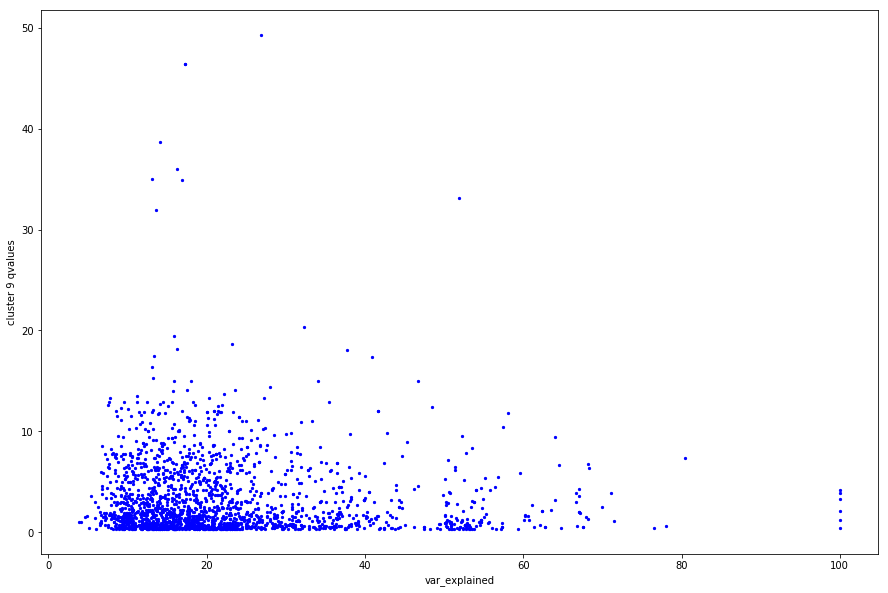

In [52]:
variance_explained = {}
for i in genes_components_per_pathway.keys():
    variance_explained[i] = genes_components_per_pathway[i][1]
    
#variance_explained = {i.keys(): i.values()[1] for i in genes_components_per_pathway}
full_clusterframe['var_explained'] = full_clusterframe.index.map(variance_explained)
full_clusterframe['var_explained'] = full_clusterframe['var_explained']*100


for i in full_clusterframe.columns:
    if i == 'var_explained':
        pass
    else:
        full_clusterframe.plot(kind='scatter', x='var_explained', y=i, color='blue', figsize=(15, 10), s=5)
        plt.show()